# Implementing protein components
this jnb gives you quick access to the implementation of protein components.


In [1]:
import gufe

## Dev function

In [2]:
#Vendored code - import
from gufe.components.sub_files.pdbfile import PDBFile

pdb_path= "./thrombin_protein.pdb"
openmm_PDBFile = PDBFile(pdb_path)

/home/riesbenj/Code/OpenFE/gufe/gufe/components/sub_files/pdbstructure.py:488: UserWarning: WARNING: two consecutive residues with same number (ATOM   4449  N   CYS L   4      10.968  17.388  19.471  1.00 16.59      L    N  , ATOM   4448  HB2 ASP L   4      10.396  20.895  17.001  1.00 39.37      L    H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


In [6]:
#Imports
from openff.toolkit.topology import Molecule
from enum import Enum

from rdkit import Chem
from rdkit.Chem.rdchem import Mol, Atom, Conformer, EditableMol, BondType


In [7]:
bond_types = {  1 : BondType.SINGLE,
                2 : BondType.DOUBLE,
                3 : BondType.TRIPLE ,
               None :  BondType.SINGLE,
               }

In [21]:
            
periodicTable = Chem.GetPeriodicTable()
mol_topology = openmm_PDBFile.topology

rd_mol = Mol()
editable_rdmol = EditableMol(rd_mol)

# Build Topology
# Add Atoms
for atom in mol_topology.atoms():
    atomID_orig = int(atom.index)
    a = Atom(atom.element.atomic_number)
    a.SetAtomMapNum(atomID_orig)

    a.SetProp("name", atom.name)
    a.SetIntProp("id", atomID_orig)

    a.SetProp("resName", atom.residue.name)
    a.SetIntProp("resId", int(atom.residue.index))

    editable_rdmol.AddAtom(a)

# Add Bonds
for bond in mol_topology.bonds():
    bond_order = bond_types[bond.order]
    editable_rdmol.AddBond(beginAtomIdx=bond.atom1.index, endAtomIdx=bond.atom2.index, order=bond_order)    

# Set Positions
rd_mol = editable_rdmol.GetMol()
positions = list(map(list, openmm_PDBFile.positions._value))
conf = Conformer(0)
for atom_id, atom_pos in enumerate(positions):
    conf.SetAtomPosition(atom_id, atom_pos) #unit: nm
rd_mol.AddConformer(conf)

# Molecule props
# Adding nums:
rd_mol.SetIntProp("NumAtoms", mol_topology.getNumAtoms())
rd_mol.SetIntProp("NumBonds", mol_topology.getNumBonds())
rd_mol.SetIntProp("NumChains", mol_topology.getNumChains())

# dimensions
pbcVs = list(map(list, mol_topology.getPeriodicBoxVectors()._value)) #unit: nm
unitCellDim = list(map(float, mol_topology.getUnitCellDimensions()._value)) #unit: nm
rd_mol.SetProp("PeriodicBoxVectors", str(pbcVs))
rd_mol.SetProp("UnitCellDimensions", str(unitCellDim))

# Sequence Settings
residue_names = [r.name for r in mol_topology.residues()]
res_seq = " ".join(residue_names) 
rd_mol.SetProp("sequence", res_seq)

# Chains
rd_mol.SetProp("chain_names", str([c.index for c in mol_topology.chains()]))
rd_mol.SetProp("chain_resi", str([[r.index for r in c.residues()] for c in mol_topology.chains()]))


# Add Additionals
# Set Bondorder


# Formal Charge
# WIP: I need Bondorder here!
atoms = rd_mol.GetAtoms()
netcharge = 0
for a in atoms:
    print(a.GetProp("resName"), periodicTable.GetElementSymbol(atomic_num), fc, connectivity)
    a.UpdatePropertyCache(strict=False)
    connectivity = len(a.GetBonds()) #a.GetTotalValence()
    atomic_num = a.GetAtomicNum()
    default_valence = periodicTable.GetDefaultValence(atomic_num)
    if(default_valence > connectivity):
        fc = -(default_valence-connectivity) # negative charge
    elif(default_valence < connectivity):
        fc = +(connectivity-default_valence) # positive charge
    else:
        fc = 0 # neutral
    
    a.SetFormalCharge(fc)
    #print(connectivity, default_valence, periodicTable.GetElementSymbol(atomic_num))

    if(fc > 0):
        print(a.GetProp("resName"), periodicTable.GetElementSymbol(atomic_num), fc, connectivity)
    netcharge+=fc
    
rd_mol.SetDoubleProp("NetCharge", netcharge)
rd_mol.UpdatePropertyCache(strict=False)

LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4
LYS N 1 4


In [20]:
a.GetPropsAsDict()

{'molAtomMapNumber': 324,
 'name': 'NZ',
 'id': 324,
 'resName': 'LYS',
 'resId': 21}

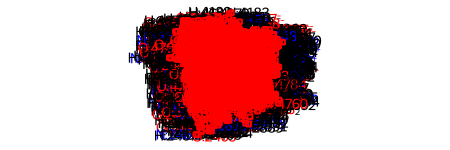

In [13]:
rd_mol

## Test

In [ ]:
#WIP

## Class Implementation

In [ ]:
# This code is part of OpenFE and is licensed under the MIT license.
# For details, see https://github.com/OpenFreeEnergy/gufe
from openff.toolkit.topology import Molecule

from rdkit import Chem
from rdkit.Chem.rdchem import Mol, Atom, Conformer, EditableMol, BondType
from openmm.app import PDBFile

from gufe.components.explicitmoleculecomponent import ExplicitMoleculeComponent
from gufe.components.sub_files.pdbfile import PDBFile


bond_types = {  1 : BondType.SINGLE,
                2 : BondType.DOUBLE,
                3 : BondType.TRIPLE ,
               None :  BondType.UNSPECIFIED,
               }
          
                    
class ProteinComponent(ExplicitMoleculeComponent):
    """Wrapper around a Protein representation.

    This representation is immutable.  If you want to make any modifications,
    do this in an appropriate toolkit then remake this class.
    """
    
    def to_pdb(self, pdb_file_path:str) -> str:
        """Create a string based on SDF.

        This is the primary serialization mechanism for this class.

        """
        Chem.MolToPDBFile(pdb_file_path)
        return pdb_file_path
    
    @classmethod
    def from_pdb_string(cls, pdbfile: str, name=""):
        pass
        
    
    @classmethod
    def from_pdbfile(cls, pdbfile: str, name=""):
        """
        _summary_

        Parameters
        ----------
        pdbfile : str
            _description_
        name : str, optional
            _description_, by default ""

        Returns
        -------
        _type_
            _description_
        """
        openmm_PDBFile = PDBFile(pdbfile)
        return cls._from_openmmPDBFile(openmm_PDBFile=openmm_PDBFile, name=name)
    
    
    @classmethod
    def _from_openmmPDBFile(cls, openmm_PDBFile:PDBFile, name:str):
        """
        This Function serializes openmmPDBFile to 
        AA - Protonations
        
        Test:        
         - 1.5 serialization test
         - check out files
         - check obj

        Parameters
        ----------
        openmm_PDBFile : PDBFile
            _description_
        name : str
            _description_

        Returns
        -------
        _type_
            _description_
        """
            
                    
        periodicTable = Chem.GetPeriodicTable()
        mol_topology = openmm_PDBFile.topology

        rd_mol = Mol()
        editable_rdmol = EditableMol(rd_mol)

        # Build Topology
        # Add Atoms
        for atom in mol_topology.atoms():
            atomID_orig = int(atom.index)
            a = Atom(atom.element.atomic_number)
            a.SetAtomMapNum(atomID_orig)

            a.SetProp("name", atom.name)
            a.SetIntProp("id", atomID_orig)

            a.SetProp("resName", atom.residue.name)
            a.SetIntProp("resId", int(atom.residue.index))

            editable_rdmol.AddAtom(a)

        # Add Bonds
        for bond in mol_topology.bonds():
            bond_order = bond_types(bond.order]
            editable_rdmol.AddBond(beginAtomIdx=bond.atom1.index, endAtomIdx=bond.atom2.index,)# order=bond_order)    

        # Set Positions
        rd_mol = editable_rdmol.GetMol()
        positions = list(map(list, openmm_PDBFile.positions._value))
        conf = Conformer(0)
        for atom_id, atom_pos in enumerate(positions):
            conf.SetAtomPosition(atom_id, atom_pos) #unit: nm
        rd_mol.AddConformer(conf)

        # Molecule props
        # Adding nums:
        rd_mol.SetIntProp("NumAtoms", mol_topology.getNumAtoms())
        rd_mol.SetIntProp("NumBonds", mol_topology.getNumBonds())
        rd_mol.SetIntProp("NumChains", mol_topology.getNumChains())

        # dimensions
        pbcVs = list(map(list, mol_topology.getPeriodicBoxVectors()._value)) #unit: nm
        unitCellDim = list(map(float, mol_topology.getUnitCellDimensions()._value)) #unit: nm
        rd_mol.SetProp("PeriodicBoxVectors", str(pbcVs))
        rd_mol.SetProp("UnitCellDimensions", str(unitCellDim))

        # Sequence Settings
        residue_names = (r.name for r in mol_topology.residues()]
        res_seq = " ".join(residue_names) 
        rd_mol.SetProp("sequence", res_seq)

        # Chains
        rd_mol.SetProp("chain_names", str([c.index for c in mol_topology.chains()]))
        rd_mol.SetProp("chain_resi", str([list([r.index for r in c.residues()]) for c in mol_topology.chains()]))


        # Add Additionals
        # Set Bondorder
        # WIP: if not possible above
        
        # Formal Charge
        # WIP: I need Bondorder here!
        atoms = rd_mol.GetAtoms()
        netcharge = 0
        for a in atoms:
            a.UpdatePropertyCache()
            connectivity = len(a.GetBonds()) #a.GetTotalValence()
            atomic_num = a.GetAtomicNum()
            default_valence = periodicTable.GetDefaultValence(atomic_num)
            if(default_valence > connectivity):
                fc = -(default_valence-connectivity) # negative charge
            elif(default_valence < connectivity):
                fc = +(connectivity-default_valence) # positive charge
            else:
                fc = 0 # neutral
            
            a.SetFormalCharge(fc)
            #print(connectivity, default_valence, periodicTable.GetElementSymbol(atomic_num))

            #if(fc > 0):
            #    print(periodicTable.GetElementSymbol(atomic_num), fc, connectivity)
            netcharge+=fc
            
        rd_mol.SetDoubleProp("NetCharge", netcharge)
        rd_mol.UpdatePropertyCache()
        # Done
        
        return cls(rdkit=rd_mol, name=name)
    
    @classmethod
    def from_pdbxfile(cls, pdbxfile: str, name=""):
        raise NotImplementedError()

    

## Build a bond ordered xml

In [ ]:
import xml.etree.ElementTree as etree

out_path = "../gufe/components/sub_files/data/residues.xml"
in_path = "../gufe/components/sub_files/data/residues_orig.xml"


exception_bond_keys = {
            # AminoAcids
            ##Backbone
            ('C', 'O'): { "order": 2, "resns": "all"},
            ## Carbonyls in R
            ("CZ", "NH2"): { "order": 2, "resns": ("ARG")},
            ("CG", "OD1"):{ "order": 2, "resns":  ("ASP", "ASN")},
            ("CD", "OE1"):{ "order": 2, "resns": ("GLN", "GlU")},
            ("CD", "OE1"):{ "order": 2, "resns": ("GlU")},
            ("CD", "OE"):{ "order": 2, "resns": ("PCA")},
            
            ## Aromatics:
            ("CD", "CG"):{ "order": 2, "resns": ("HIS")},
            ("CE1", "NE2"):{ "order": 2, "resns": ("HIS")},
            
            ("CG", "CD1"):{ "order": 2, "resns": ("PHE")},
            ("CE1", "CZ"):{ "order": 2, "resns": ("PHE")},
            ("CE2", "CD2"):{ "order": 2, "resns": ("PHE")},
            
            ("CD1", "NE1"):{ "order": 2, "resns": ("TRP")},
            ("CD2", "CE3"):{ "order": 2, "resns": ("TRP")},
            ("CE2", "CZ2"):{ "order": 2, "resns": ("TRP")},
            ("CZ3", "CH2"):{ "order": 2, "resns": ("TRP")},

            ("CG", "CD1"):{ "order": 2, "resns": ("TYR")},
            ("CE1", "CZ"):{ "order": 2, "resns": ("TYR")},
            ("CD2", "CE2"):{ "order": 2, "resns": ("TYR")},

            # NucleicAcids
            ## Phosphates
            ("OP1", "P"):{ "order": 2, "resns": ("U", "G", "A", "C", "DT", "DG", "DC", "DA")},
            
            ## Pyrimidines: Uracil, Thymin and Cytosin
            ("C2", "O2"):{ "order": 2, "resns": ("U", "DT", "C", "DC")},
            ("C5", "C6"):{ "order": 2, "resns": ("U", "DT", "C", "DC")},
            ("C4", "O4"):{ "order": 2, "resns": ("U", "DT")},
            ("C4", "N3"):{ "order": 2, "resns": ("C", "DC")},

            ## Purines: Guanine, Adenine
            ("C2", "N3"):{ "order": 2, "resns": ("G", "DG", "A", "DA")},
            ("C4", "C5"):{ "order": 2, "resns": ("G", "DG", "A", "DA")},
            ("N7", "C8"):{ "order": 2, "resns": ("G", "DG", "A", "DA")},
            ("C6", "O6"):{ "order": 2, "resns": ("G", "DG")},
            ("C6", "N1"):{ "order": 2, "resns": ("A", "DA")},            
             }

In [ ]:
tree = etree.parse(in_path)

for residue in tree.getroot().findall('Residue'):
    resn = residue.get("name")
    #print(residue.get("name"))
    for bond in residue.findall("Bond"):
        #print(bond)
        c1 = bond.get("from")
        c2 = bond.get("to")
        bond_atoms=tuple(sorted([c1, c2]))
        
        if(bond_atoms in exception_bond_keys and (not "resn" in exception_bond_keys[bond_atoms] or exception_bond_keys[bond_atoms]["resn"] == resn)):
            bond.set("order", str(exception_bond_keys[bond_atoms]["order"]))
        else:
            bond.set("order", str(1))
tree.write(out_path)